In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from sklearn.discriminant_analysis import StandardScaler
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA   
from statsmodels.tsa.api import VAR
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

import sklearn.preprocessing as preprocessing
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

import scipy.optimize as opt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

import random
from collections import deque
import sympy as sp

plt.style.use('dark_background')

## Preprocess

In [2]:
def create_lag_features(df, column, lag_count):
    for lag in range(1, lag_count + 1):
        df[f'{column}_lag_{lag}'] = df[column].shift(lag)
    return df
def create_rolling_features(df, column, window_size):
    for window in range(1, window_size + 1):
        df[f'{column}_rolling_{window}'] = df[column].rolling(window).mean()
    return df

In [4]:
data = pd.merge(
    pd.read_excel('train.xlsx', sheet_name='Sheet1', index_col=0, parse_dates=True),     
    pd.read_excel('train.xlsx', sheet_name='Sheet2', index_col=0, parse_dates=True), 
    left_index=True, right_index=True, how='outer'
).interpolate('quadratic').dropna()
data['irradiance'].clip(lower=0, inplace=True)
data['pri_heat'] = (data['pri_supp_t'] - data['pri_back_t']) * data['pri_flow']
data['sec_heat'] = (data['sec_supp_t'] - data['sec_back_t']) * data['sec_flow']

X_columns = [
    'pri_supp_t',
    'pri_back_t',
    'pri_flow',
    'sec_supp_t',
    'sec_back_t',
    'sec_flow',
    'pri_heat',
    'sec_heat',
    'outdoor',
    'irradiance',
]
X = data.loc[:, data.columns != 'indoor']
y = data['indoor']
delay = 10
for col in X_columns:
    create_lag_features(X, col, delay)
    create_rolling_features(X, col, delay)
create_lag_features(X, 'irradiance', 1)
y = y[~X.isna().any(axis=1)]
X.dropna(inplace=True)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_23276\1813665084.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{column}_rolling_{window}'] = df[column].rolling(window).mean()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_23276\1813665084.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{column}_lag_{lag}'] = df[column].shift(lag)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_23276\1813665084.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.

In [ ]:
#       - - - - - - + + + + + +
#y:                 1 2 3 4 5 6
#10min            1 2 3 4 5 6
#60min  1 2 3 4 5 6

In [178]:
data = (
    pd.merge(
        pd.read_excel("train.xlsx", sheet_name="Sheet1", index_col=0, parse_dates=True),
        pd.read_excel("train.xlsx", sheet_name="Sheet2", index_col=0, parse_dates=True),
        left_index=True,
        right_index=True,
        how="outer",
    )
    .interpolate("quadratic")
    .dropna()
)
data["irradiance"].clip(lower=0, inplace=True)
data["sec_heat"] = (data["sec_supp_t"] - data["sec_back_t"]) * data["sec_flow"]

for col in [
    'sec_supp_t',
    'sec_back_t',
    'indoor',
    'outdoor',
]:
    data[f'{col}_flow'] = data[col] * data['sec_flow']
for col in [
    'sec_supp_t',
    'sec_supp_t_flow',
    'sec_back_t',
    "sec_heat",
    "sec_flow",
    'indoor',
    'indoor_flow',
    'outdoor',
    'outdoor_flow',
    "irradiance",
]:
    for i in range(1, 1+24):
        data[f'{col}_{i}0min'] = data[col].shift(i)


data['diff_t_60min'] = (data['sec_supp_t'] + data['sec_back_t']) / 2 - data['indoor_60min']
# data['irradiance_20min'] = data['irradiance'].rolling(2).mean()

        
X_columns = [
    "sec_supp_t",
    "sec_supp_t_60min",
    "sec_supp_t_120min",
    "sec_supp_t_180min",
    # "sec_supp_t_flow_60min",
    # "sec_heat_60min",
    # "sec_flow",
    # "sec_flow_60_min",
    "sec_back_t",
    "sec_back_t_60min",
    "sec_back_t_120min",
    # "indoor_flow_60min",
    "irradiance",
    "irradiance_60min",
    "irradiance_120min",
    # "indoor_10min",
    "indoor_60min",
    # "indoor_70min",
    # "indoor_80min",
    # "indoor_90min",
    # "indoor_100min",
    # "indoor_110min",
    "indoor_120min",
    # "diff_t_60min",
    "outdoor",
    "outdoor_60min",
    "outdoor_120min",
]


# X_columns = [
#     "sec_supp_t_60min",
#     "sec_back_t_60min",
#     "sec_back_t_120min",
#     "indoor_60min",
#     "indoor_120min",
# ]






X = data.loc[:, X_columns]
y1 = data['indoor']
y2 = data['sec_back_t']
# X = X.resample('1H').mean().ewm(alpha=1).mean()
# y = y.resample('1H').mean().ewm(alpha=1).mean()

X = X.resample("1H").mean()
y1 = y1.resample("1H").mean()
y2 = y2.resample("1H").mean()
delay = 1

# X['indoor_60min'] = y.shift(1)
# X['indoor_60min'] = y1.shift(1)
# X['indoor_120min'] = y.shift(2)

# X['indoor_70min'] = X['indoor_10min'].shift(1)
# X['irradiance_60min'] = X['irradiance'].shift(1)


# y += 273.15
# y = np.log(y).diff()
y = y1.diff()
nona = ~X.isna().any(axis=1) & ~y.isna()
X = X[nona]
y = y[nona]

train_idx = (X.index <= '2021-12-20') | \
            (X.index >= '2022-1-1') & (X.index <= '2022-1-20') | \
            (X.index >= '2022-2-1') & (X.index <= '2022-2-20')
train_idx
test_idx = ~train_idx

X_train, X_test = X.loc[train_idx], X.loc[test_idx]
y_train, y_test = y.loc[train_idx], y.loc[test_idx]
print(X_train.shape, X_test.shape)

(1178, 15) (717, 15)


C:\Users\Administrator\AppData\Local\Temp\ipykernel_14604\788738516.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'{col}_{i}0min'] = data[col].shift(i)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_14604\788738516.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'{col}_{i}0min'] = data[col].shift(i)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_14604\788738516.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

In [87]:
split = np.datetime64('2022-02-01')
X_train, X_test = X.loc[:split], X.loc[split:]
y_train, y_test = y.loc[:split], y.loc[split:]
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1297, 7) (600, 7) (1297,) (600,)


## Physical model

In [79]:
data['sec_supp_t']

date
2021-12-08 22:40:00    35.313000
2021-12-08 22:50:00    35.266000
2021-12-08 23:00:00    35.243000
2021-12-08 23:10:00    35.247000
2021-12-08 23:20:00    35.249000
                         ...    
2022-02-25 22:20:00    35.357000
2022-02-25 22:30:00    35.356667
2022-02-25 22:40:00    35.297500
2022-02-25 22:50:00    35.301250
2022-02-25 23:00:00    35.280000
Name: sec_supp_t, Length: 11379, dtype: float64

In [81]:
data['sec_flow'] # T / h
data['sec_flow'] * 1000 / 3600 # kg / s

date
2021-12-08 22:40:00    17.191111
2021-12-08 22:50:00    17.351111
2021-12-08 23:00:00    17.727222
2021-12-08 23:10:00    17.297500
2021-12-08 23:20:00    17.396111
                         ...    
2022-02-25 22:20:00    23.622222
2022-02-25 22:30:00    23.593981
2022-02-25 22:40:00    23.995139
2022-02-25 22:50:00    23.667361
2022-02-25 23:00:00    23.664583
Name: sec_flow, Length: 11379, dtype: float64

3.0371598557907493 9.809576372648043e-09 2.186811789946547e-05 -105406.01522104166 -3.1358901923382136


(18993.0, 18994.0)

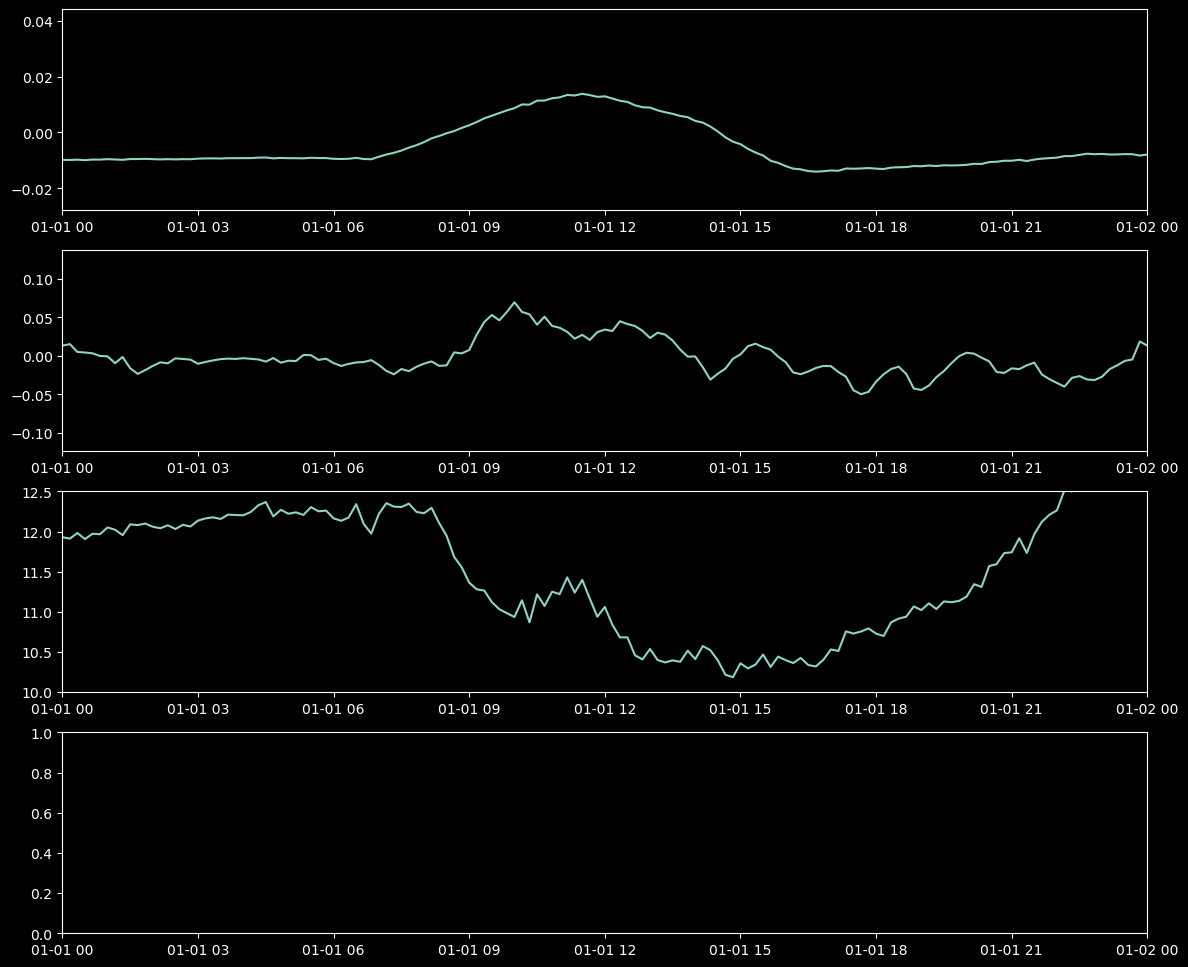

In [426]:
supp_t = data["sec_supp_t"] + 273.15  # K
back_t = data["sec_back_t"] + 273.15  # K
indoor_t = data["indoor"] + 273.15  # K
indoor_t_smooth = indoor_t.rolling(6).mean()
outdoor_t = data["outdoor"] + 273.15  # K
flow = data["sec_flow"] * 1000 / 3600  # kg / s
c_water = 4200  # J/(kg·K)

W_water = flow * c_water * (supp_t - back_t)  # kg / s * J/(kg·K) * K = J / s = W
E_water = W_water.cumsum() * 10 * 60
E_water

# heat emission
k_irradiance = 10
k_emmission = 10000
irradiance = data["irradiance"]


def f(x, k_irradiance, k_emmission, k, a, b):
    supp_t, back_t, flow, indoor_t, outdoor_t, irradiance = x
    W_water = flow * (supp_t - back_t) + \
        a * ((supp_t + back_t) / 2 - indoor_t) ** (1+b)
    W_emmission = k_emmission * (outdoor_t - indoor_t) + k_irradiance * irradiance
    delta_t = (W_water + W_emmission) * k # / 1000
    return delta_t


def f(x, k1, k2, k3, c):
    return supp_t * k1 + back_t * k2 + indoor_t * k3 + c


(k_irradiance, k_emmission, k, a, b), pcov = opt.curve_fit(
    f, 
    xdata=(supp_t[:-6], back_t[:-6], flow[:-6], indoor_t[:-6], outdoor_t[:-6], irradiance[:-6]), 
    ydata=indoor_t.rolling(window=6).median().diff()[6:],
    bounds=([0, 0, 0, -np.inf, -np.inf], [np.inf, np.inf, np.inf, np.inf, np.inf]),
)

print(k_irradiance, k_emmission, k, a, b)

plt.figure(figsize=(14, 12))
plt.subplot(4, 1, 1)
plt.plot(
    f(
        (
            data["sec_supp_t"] + 273.15,
            data["sec_back_t"] + 273.15,
            data["sec_flow"] * 1000 / 3600,
            data["indoor"] + 273.15,
            data["outdoor"] + 273.15,
            data["irradiance"],
        ),
        k_irradiance=k_irradiance,
        k_emmission=k_emmission,
        k=k,
        a=a,
        b=b
    )
)
split = np.datetime64("2022-01-01")
plt.xlim(split, split + 1)
plt.subplot(4, 1, 2)
# plt.plot(indoor_t)
plt.plot(indoor_t.rolling(window=6).median().diff().ewm(span=6).mean())
# plt.plot(indoor_t_smooth.diff())
plt.xlim(split, split + 1)
# plt.plot(irradiance / 70000 * 8 - 0.01)

plt.subplot(4, 1, 3)
plt.plot((data['sec_supp_t'] + data['sec_back_t']) / 2 - data['indoor'])
plt.xlim(split, split + 1)
plt.ylim(10, 12.5)

plt.subplot(4, 1, 4)
plt.xlim(split, split + 1)
# plt.plot(data['sec_flow'])

# plt.ylim(-0.02, 0.035)
# indoor_t
# data['sec_supp_t']

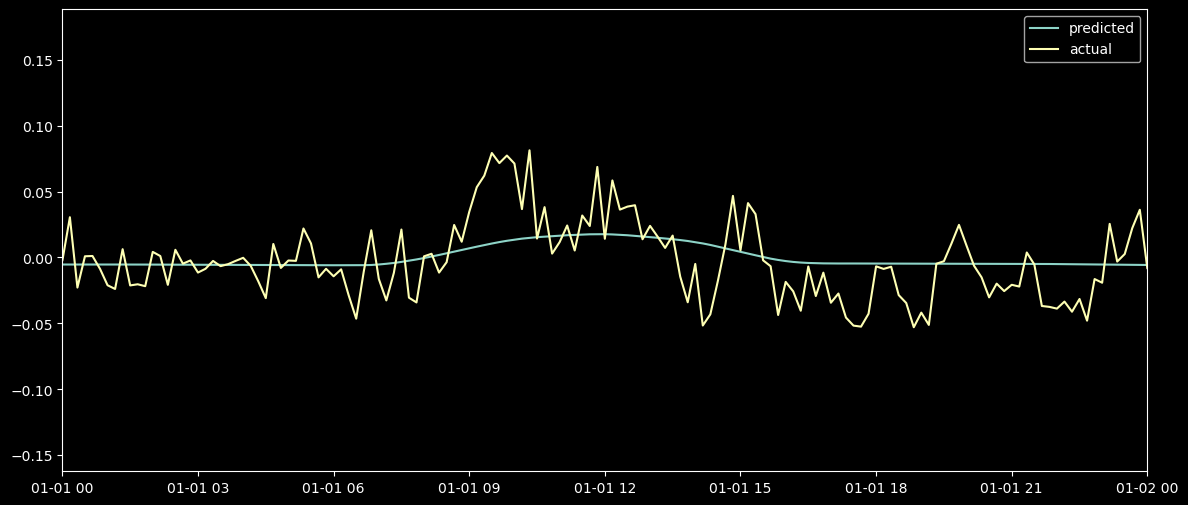

In [234]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.k_irradiance = nn.Parameter(torch.tensor(k_irradiance))
        self.k_emmission = nn.Parameter(torch.tensor(k_emmission))
        self.k = nn.Parameter(torch.tensor(k))
        self.c_water = torch.tensor(c_water)
        
    def forward(self, supp_t, back_t, flow, indoor_t, outdoor_t, irradiance):
        W_water = flow * self.c_water * (supp_t - back_t)
        W_emmission = self.k_emmission * (outdoor_t - indoor_t) + self.k_irradiance * irradiance
        return (W_water + W_emmission) / self.k
    
pred_model = Model()
W_all = pred_model(
    torch.tensor(data["sec_supp_t"]),
    torch.tensor(data["sec_back_t"]),
    torch.tensor(data["sec_flow"] * 1000 / 3600),
    torch.tensor(data["indoor"]),
    torch.tensor(data["outdoor"]),
    torch.tensor(data["irradiance"]),
)
plt.figure(figsize=(14, 6))
plt.plot(pd.Series(W_all.detach().numpy(), index=data.index))
plt.plot(indoor_t_smooth.diff())
plt.xlim(split, split + 1)
plt.legend(["predicted", "actual"])



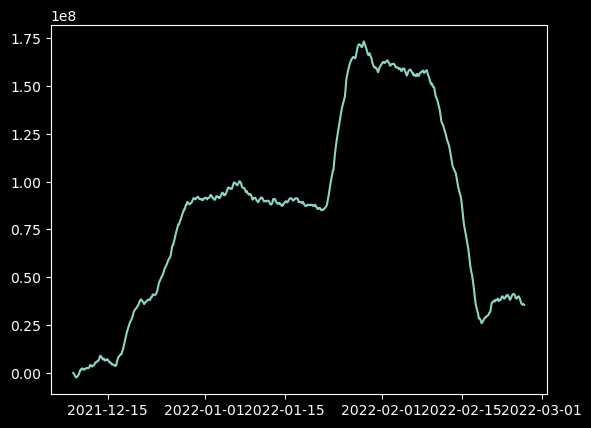

In [210]:
plt.plot(f(
    (
        data["sec_supp_t"] + 273.15,
        data["sec_back_t"] + 273.15,
        data["sec_flow"] * 1000 / 3600,
        data["indoor"] + 273.15,
        data["outdoor"] + 273.15,
        data["irradiance"],
    ),
    k_irradiance=k_irradiance,
    k_emmission=k_emmission,
).cumsum())

In [236]:
class LitModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = Model()
        self.loss = nn.MSELoss()
        
    def forward(self, supp_t, back_t, flow, indoor_t, outdoor_t, irradiance):
        return self.model(supp_t, back_t, flow, indoor_t, outdoor_t, irradiance)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer
    
    def train_dataloader(self):
        return DataLoader(
            TensorDataset(
                torch.tensor(data["sec_supp_t"]),
                torch.tensor(data["sec_back_t"]),
                torch.tensor(data["sec_flow"] * 1000 / 3600),
                torch.tensor(data["indoor"]),
                torch.tensor(data["outdoor"]),
                torch.tensor(data["irradiance"]),
                torch.tensor(indoor_t_smooth.diff()),
            ),
            batch_size=128,
            shuffle=True,
        )
    
    def training_step(self, batch, batch_idx):
        supp_t, back_t, flow, indoor_t, outdoor_t, irradiance, target = batch
        pred = self(supp_t, back_t, flow, indoor_t, outdoor_t, irradiance)
        loss = self.loss(pred, target)
        self.log('train_loss', loss)
        return loss
    
pred_model = LitModel()
trainer = pl.Trainer(max_epochs=100)
trainer.fit(pred_model)
pred_model.eval()
pred_model

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: d:\ShanghaiTech\ARTS1425\ARTS1425-Project\lightning_logs

  | Name  | Type    | Params
----------------------------------
0 | model | Model   | 3     
1 | loss  | MSELoss | 0     
----------------------------------
3         Trainable params
0         Non-trainable params
3         Total params
0.000     Total estimated model params size (MB)
c:\ProgramData\miniconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


LitModel(
  (model): Model()
  (loss): MSELoss()
)

In [238]:
pred_model.model.k_emmission

Parameter containing:
tensor(nan, dtype=torch.float64, requires_grad=True)

(18993.0, 18994.0)

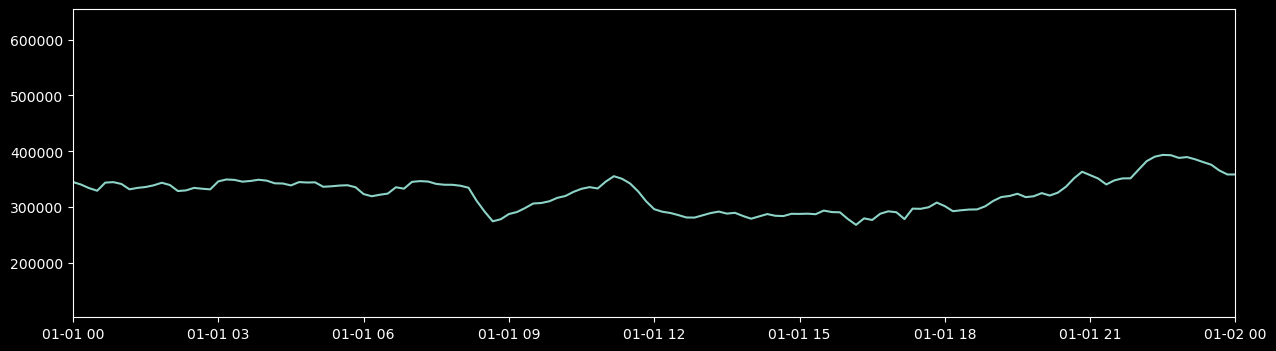

In [102]:
plt.figure(figsize=(15, 4))
plt.plot(W_water)

## Naive

In [5]:
def fit_and_test_scaled_log_return(model):

    scaler = StandardScaler()
    scaler.fit(pd.concat([X_train, y_train], axis=1))
    Xy_scaled = pd.DataFrame(scaler.transform(pd.concat([X, y], axis=1)), columns=X.columns.tolist() + ['indoor'], index=X.index)
    X_scaled, y_scaled = Xy_scaled.iloc[:, :-1], Xy_scaled.iloc[:, -1]
    X_train_scaled, X_test_scaled = X_scaled[:split], X_scaled[split:]
    y_train_scaled, y_test_scaled = y_scaled[:split], y_scaled[split:]


    model_fit = model.fit(X_train_scaled, y_train_scaled)
    d_pred_scaled = model_fit.predict(X_scaled)
    d_pred = scaler.inverse_transform(np.concatenate([X_scaled, d_pred_scaled.reshape(-1, 1)], axis=1))[:, -1]
    print('train score:\t', model.score(X_train_scaled, y_train_scaled))
    print('test score:\t', model.score(X_test_scaled, y_test_scaled))
    print()
    print('self RMSE:\t', np.sqrt(((y_scaled - y_scaled.shift(1)) ** 2).mean())) 
    print('pred RMSE:\t', np.sqrt(((y_scaled - d_pred_scaled) ** 2).mean()))
    print('train RMSE:\t', np.sqrt(((y_train_scaled - d_pred_scaled[: y_train_scaled.shape[0]]) ** 2).mean()))
    print('test RMSE:\t', np.sqrt(((y_test_scaled - d_pred_scaled[-y_test_scaled.shape[0] :]) ** 2).mean()))
    plt.figure(figsize=(14, 6))
    plt.subplot(2, 1, 1)

    plt.plot(pd.Series(d_pred, index=y.index))
    plt.plot(pd.Series(y, index=y.index))
    plt.plot([split, split], [y.min(), y.max()], "r--")
    plt.legend(["Predicted", "Actual"])
    plt.xlim(split - 2, split + 5)
    print()

    y_true = data["indoor"].resample("1H").mean()
    y_pred = (data["indoor"].resample("1H").mean().shift(1) + 273.15) * np.exp(
        pd.Series(d_pred, index=y.index)
    ) - 273.15
    print('self RMSE:\t', np.sqrt(((y_true - y_true.shift(1)) ** 2).mean()))
    print('pred RMSE:\t', np.sqrt(((y_true - y_pred) ** 2).mean()))
    print('train RMSE:\t', np.sqrt(((y_true[:split] - y_pred[:split]) ** 2).mean()))
    print('test RMSE:\t', np.sqrt(((y_true[split:] - y_pred[split:]) ** 2).mean()))
    plt.subplot(2, 1, 2)
    plt.plot(y_pred)
    plt.plot(y_true)
    plt.plot([split, split], [y_true.min(), y_true.max()], "r--")
    plt.xlim(split - 2, split + 5)
    plt.legend(["Predicted", "Actual"])


In [6]:
def fit_and_test_log_return(model):
    
    model_fit = model.fit(X_train, y_train)
    d_pred = model_fit.predict(X)
    print('train score:\t', model.score(X_train, y_train))
    print('test score:\t', model.score(X_test, y_test))
    print()
    print('self RMSE:\t', np.sqrt(((y - y.shift(1)) ** 2).mean())) 
    print('pred RMSE:\t', np.sqrt(((y - d_pred) ** 2).mean()))
    print('train RMSE:\t', np.sqrt(((y_train - d_pred[: y_train.shape[0]]) ** 2).mean()))
    print('test RMSE:\t', np.sqrt(((y_test - d_pred[-y_test.shape[0] :]) ** 2).mean()))
    plt.figure(figsize=(14, 6))
    plt.subplot(2, 1, 1)
    plt.plot(pd.Series(d_pred, index=y.index))
    plt.plot(pd.Series(y, index=y.index))
    plt.plot([split, split], [y.min(), y.max()], "r--")
    plt.legend(["Predicted", "Actual"])
    plt.xlim(split - 2, split + 5)
    print()

    y_true = data["indoor"].resample("1H").mean()
    y_pred = (data["indoor"].resample("1H").mean().shift(1) + 273.15) * np.exp(
        pd.Series(d_pred, index=y.index)
    ) - 273.15
    print('self RMSE:\t', np.sqrt(((y_true - y_true.shift(1)) ** 2).mean()))
    print('pred RMSE:\t', np.sqrt(((y_true - y_pred) ** 2).mean()))
    print('train RMSE:\t', np.sqrt(((y_true[:split] - y_pred[:split]) ** 2).mean()))
    print('test RMSE:\t', np.sqrt(((y_true[split:] - y_pred[split:]) ** 2).mean()))
    plt.subplot(2, 1, 2)
    plt.plot(y_pred)
    plt.plot(y_true)
    plt.plot([split, split], [y_true.min(), y_true.max()], "r--")
    plt.xlim(split - 2, split + 5)
    plt.legend(["Predicted", "Actual"])


In [7]:
def fit_and_test_scaled(model):

    scaler = StandardScaler()
    scaler.fit(pd.concat([X_train, y_train], axis=1))
    Xy_scaled = pd.DataFrame(scaler.transform(pd.concat([X, y], axis=1)), columns=X.columns.tolist() + ['indoor'], index=X.index)
    X_scaled, y_scaled = Xy_scaled.iloc[:, :-1], Xy_scaled.iloc[:, -1]
    X_train_scaled, X_test_scaled = X_scaled[:split], X_scaled[split:]
    y_train_scaled, y_test_scaled = y_scaled[:split], y_scaled[split:]


    model_fit = model.fit(X_train_scaled, y_train_scaled)
    d_pred_scaled = model_fit.predict(X_scaled)
    d_pred = scaler.inverse_transform(np.concatenate([X_scaled, d_pred_scaled.reshape(-1, 1)], axis=1))[:, -1]
    print('train score:\t', model.score(X_train_scaled, y_train_scaled))
    print('test score:\t', model.score(X_test_scaled, y_test_scaled))
    print()
    print('self RMSE:\t', np.sqrt(((y_scaled - y_scaled.shift(1)) ** 2).mean())) 
    print('pred RMSE:\t', np.sqrt(((y_scaled - d_pred_scaled) ** 2).mean()))
    print('train RMSE:\t', np.sqrt(((y_train_scaled - d_pred_scaled[: y_train_scaled.shape[0]]) ** 2).mean()))
    print('test RMSE:\t', np.sqrt(((y_test_scaled - d_pred_scaled[-y_test_scaled.shape[0] :]) ** 2).mean()))
    plt.figure(figsize=(14, 6))
    plt.subplot(2, 1, 1)

    plt.plot(pd.Series(d_pred, index=y.index))
    plt.plot(pd.Series(y, index=y.index))
    plt.plot([split, split], [y.min(), y.max()], "r--")
    plt.legend(["Predicted", "Actual"])
    plt.xlim(split - 2, split + 5)
    print()

    y_true = data["indoor"].resample("1H").mean()
    y_pred = y_true.shift(1) + pd.Series(d_pred, index=y.index) 
    print('self RMSE:\t', np.sqrt(((y_true - y_true.shift(1)) ** 2).mean()))
    print('pred RMSE:\t', np.sqrt(((y_true - y_pred) ** 2).mean()))
    print('train RMSE:\t', np.sqrt(((y_true[:split] - y_pred[:split]) ** 2).mean()))
    print('test RMSE:\t', np.sqrt(((y_true[split:] - y_pred[split:]) ** 2).mean()))
    plt.subplot(2, 1, 2)
    plt.plot(y_pred)
    plt.plot(y_true)
    plt.plot([split, split], [y_true.min(), y_true.max()], "r--")
    plt.xlim(split - 2, split + 5)
    plt.legend(["Predicted", "Actual"])

    return model_fit


In [12]:
split = np.datetime64("2022-02-01")
def fit_and_test(model, xlim=(split-5, split+5)):
    
    model_fit = model.fit(X_train, y_train)
    d_pred = model_fit.predict(X)
    print('train score:\t', model.score(X_train, y_train))
    print('test score:\t', model.score(X_test, y_test))
    print()
    print('self RMSE:\t', np.sqrt(((y - y.shift(1)) ** 2).mean())) 
    print('pred RMSE:\t', np.sqrt(((y - d_pred) ** 2).mean()))
    print('train RMSE:\t', np.sqrt(((y_train - d_pred[: y_train.shape[0]]) ** 2).mean()))
    print('test RMSE:\t', np.sqrt(((y_test - d_pred[-y_test.shape[0] :]) ** 2).mean()))
    plt.figure(figsize=(14, 6))
    plt.subplot(2, 1, 1)
    plt.plot(pd.Series(d_pred, index=y.index))
    plt.plot(pd.Series(y, index=y.index))
    plt.plot([split, split], [y.min(), y.max()], "r--")
    plt.legend(["Predicted", "Actual"])
    plt.xlim(*xlim)
    print()

    y_true = data["indoor"].resample("1H").mean()[nona]
    y_pred = y_true.shift(1) + pd.Series(d_pred, index=y.index)
    print('self RMSE:\t', np.sqrt(((y_true - y_true.shift(1)) ** 2).mean()))
    print('pred RMSE:\t', np.sqrt(((y_true - y_pred) ** 2).mean()))
    print('train RMSE:\t', np.sqrt(((y_true[train_idx] - y_pred[train_idx]) ** 2).mean()))
    print('test RMSE:\t', np.sqrt(((y_true[test_idx] - y_pred[test_idx]) ** 2).mean()))
    plt.subplot(2, 1, 2)
    plt.plot(y_pred)
    plt.plot(y_true)
    plt.plot([split, split], [y_true.min(), y_true.max()], "r--")
    plt.xlim(*xlim)
    plt.legend(["Predicted", "Actual"])

    return model_fit


train score:	 0.8180099103667261
test score:	 0.23958856076679125

self RMSE:	 0.18623056422866882
pred RMSE:	 0.09821886736023362
train RMSE:	 0.138561257061202
test RMSE:	 0.15592106461694216

self RMSE:	 0.15640591250274763
pred RMSE:	 0.09824267666860198
train RMSE:	 0.06730434709926846
test RMSE:	 0.13438486284801646


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=20, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

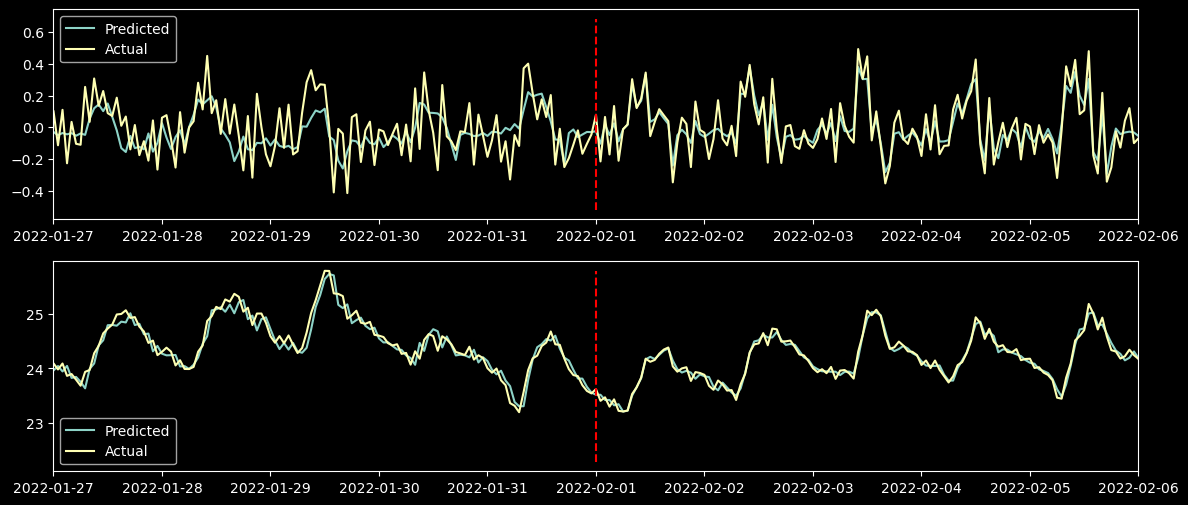

In [180]:
fit_and_test(XGBRegressor(
    n_estimators=20,
    learning_rate=0.2,
))

train score:	 0.42930697415932517
test score:	 0.344820542908587

self RMSE:	 0.18623056422866882
pred RMSE:	 0.1212910717191722
train RMSE:	 0.1380874283709887
test RMSE:	 0.14098368539684936

self RMSE:	 0.15640591250274763
pred RMSE:	 0.12132036446439844
train RMSE:	 0.1191890480842905
test RMSE:	 0.12474012288480733


SVR(C=0.1, kernel='linear')

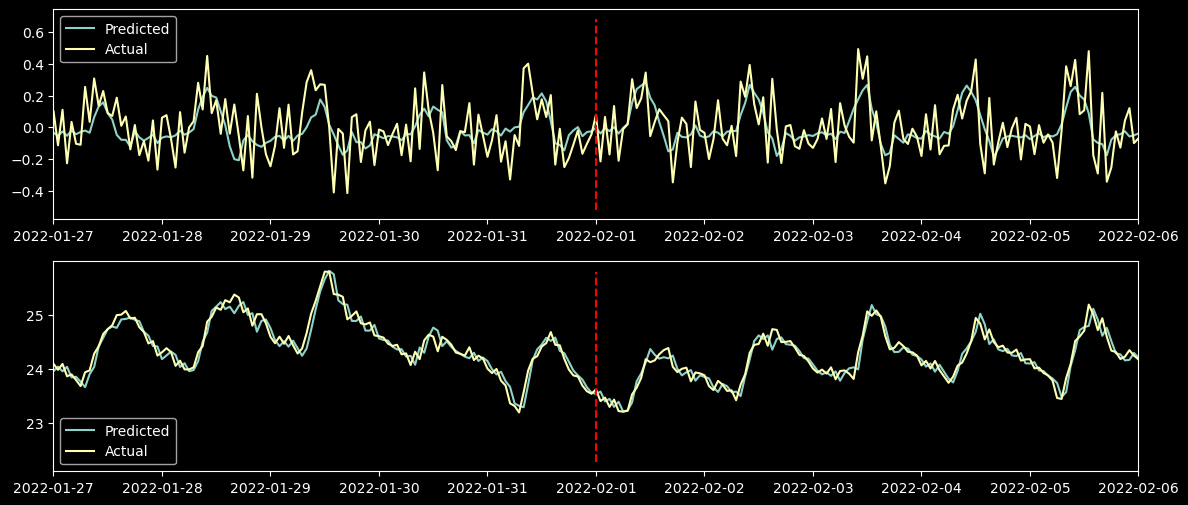

In [181]:
fit_and_test(SVR(kernel='linear', C=0.1))

In [15]:
print((data['indoor'] - data['indoor'].shift(6)).abs().mean() / 6)
print((data['indoor'].resample('1h').mean() - data['indoor'].shift(1).resample('1h').mean()).abs().mean())

0.027577534552294156
0.02755101128775957


In [16]:
print((data['indoor'] - data['indoor'].shift(6)).abs().mean())
print((data['indoor'].resample('1h').mean() - data['indoor'].shift(1).resample('1h').mean()).abs().mean() * 6)

0.16546520731376493
0.16530606772655743


train score:	 0.1300577642576617
test score:	 -0.7377162033502289

self RMSE:	 0.18623056422866882
pred RMSE:	 0.17048793718890898
train RMSE:	 0.1932251501433791
test RMSE:	 0.20123081809236174

self RMSE:	 0.15640591250274763
pred RMSE:	 0.17053162701942048
train RMSE:	 0.14715984074180077
test RMSE:	 0.20314935931277875


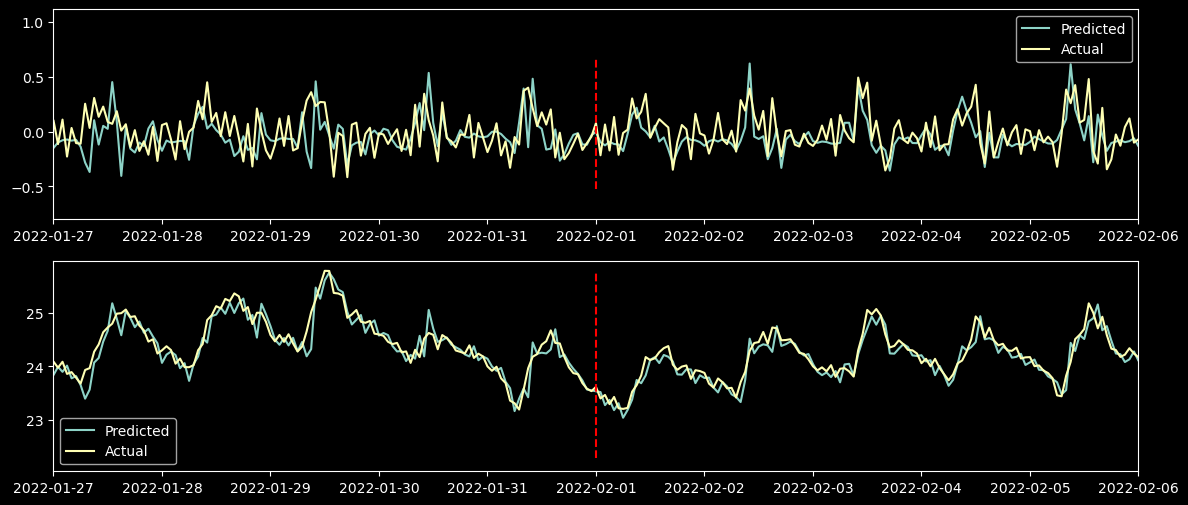

In [194]:
model_fit = fit_and_test(MLPRegressor(
    hidden_layer_sizes=(64, 64, 64), 
    activation='relu',
    learning_rate='constant',
    learning_rate_init=0.001,
    random_state=42,
    # verbose=True,
    shuffle=True,
))

# significent = np.abs(model_fit.coef_) > 1e-3
# display(dict(zip(model_fit.feature_names_in_, model_fit.coef_)))
# display(dict(zip(model_fit.feature_names_in_[significent], model_fit.coef_[significent])))

train score:	 0.43153764292376395
test score:	 0.3394334182307702

self RMSE:	 0.18623056422866882
pred RMSE:	 0.12134842955000574
train RMSE:	 0.1390124844126446
test RMSE:	 0.14086771016641525

self RMSE:	 0.15640591250274763
pred RMSE:	 0.12137725706107476
train RMSE:	 0.11895507447864777
test RMSE:	 0.12525190244303958


{'sec_supp_t': -0.07445398538232788,
 'sec_supp_t_60min': -0.04531115826023637,
 'sec_supp_t_120min': 0.05242982228206976,
 'sec_supp_t_180min': 0.06163045099776027,
 'sec_back_t': 0.22536185353327146,
 'sec_back_t_60min': -0.08009545201617314,
 'sec_back_t_120min': -0.13291635237548532,
 'irradiance': 0.0002441777719561497,
 'irradiance_60min': 0.0009141607118250475,
 'irradiance_120min': -0.0008376638146797153,
 'indoor_60min': -0.14980713280029517,
 'indoor_120min': 0.09215303413080916,
 'outdoor': 0.01093782758119839,
 'outdoor_60min': -0.0032745950335385503,
 'outdoor_120min': -0.002059509441181157}

{'sec_supp_t': -0.07445398538232788,
 'sec_supp_t_60min': -0.04531115826023637,
 'sec_supp_t_120min': 0.05242982228206976,
 'sec_supp_t_180min': 0.06163045099776027,
 'sec_back_t': 0.22536185353327146,
 'sec_back_t_60min': -0.08009545201617314,
 'sec_back_t_120min': -0.13291635237548532,
 'indoor_60min': -0.14980713280029517,
 'indoor_120min': 0.09215303413080916,
 'outdoor': 0.01093782758119839,
 'outdoor_60min': -0.0032745950335385503,
 'outdoor_120min': -0.002059509441181157}

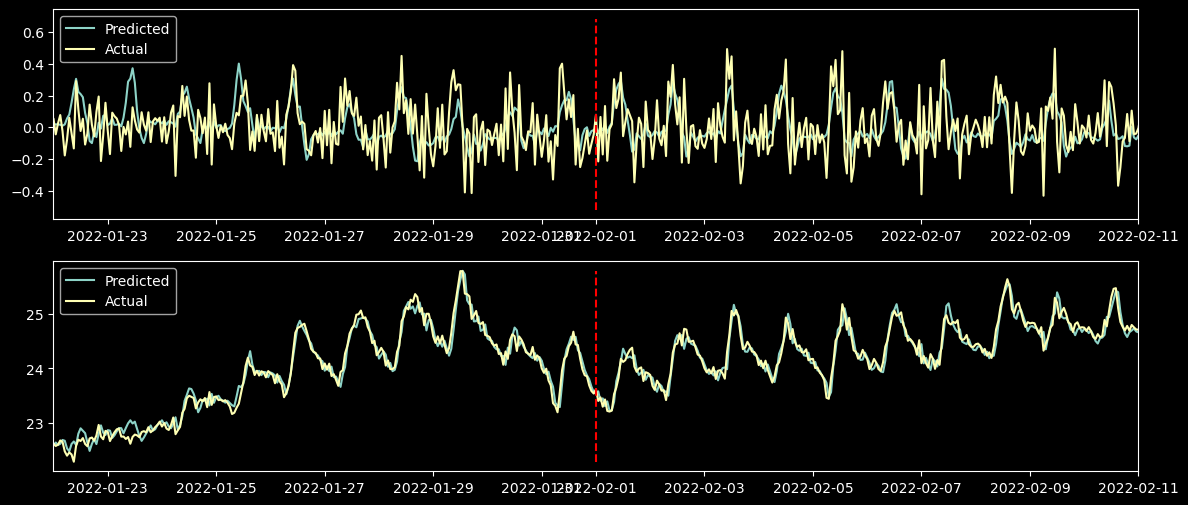

In [196]:
model_fit = fit_and_test(LinearRegression(), (split - 10, split + 10))

significent = np.abs(model_fit.coef_) > 1e-3
display(dict(zip(model_fit.feature_names_in_, model_fit.coef_)))
display(dict(zip(model_fit.feature_names_in_[significent], model_fit.coef_[significent])))

In [ ]:
class Environment:

    State = pd.Series
    Action = float      # the increase or decrease of `sec_supp_t` per hour
    Reward = float


    def __init__(
            self, data: pd.DataFrame, pred_model: LinearRegression, start_time: pd.Timestamp
        ) -> None:
            self.data = data.copy()
            self.start_time = start_time.round('H')  # Round start_time to the nearest hour
            self.pred_model = pred_model

            self.X_cols: list[str] = pred_model.feature_names_in_

            self.reset()
            pass

    def reset(self) -> None:
        self.X = self.data.loc[:, self.X_cols].resample('H').mean()
        self.y = self.data['indoor'].resample('H').mean()
        self.S = self._get_initial_state()
        self.T = self.start_time
        self.X.loc[self.T:, 'indoor'] = np.nan
        pass

    def step(self, A: Action) -> tuple[State, Reward, bool]:
        # Apply the action to the environment
        # Return the next state, reward, done (whether the episode is finished), and additional info
        S_ = self._get_next_state(self.S, A)
        R = self._get_reward(self.S, A, S_)
        D = self._is_done(S_)
        self.S = S_
        self.T += pd.Timedelta('1H')
        self.X
        return S_, R, D

    def render(self) -> None:
        print(self.X.loc[self.T])

    def close(self) -> None:
        print('Close')

    #############################################################

    def _get_initial_state(self) -> State:
        return self.X.loc[self.start_time]

    def _get_next_state(self, S: State, A: Action) -> State:
        assert abs(A) <= 2
        T: pd.Timestamp = S.name
        S = S.copy()
        S['sec_supp_t'] += A
        S_ = self.X.loc[T + pd.Timedelta('1H')].copy()
        S_['indoor'] = self.pred_model.predict(S.values.reshape(1, -1))[0]
        return S_

    def _get_reward(self, S: State, A: Action, S_: State) -> Reward:
        R = S_['indoor'] - 22
        return R

    def _is_done(self, state: pd.Series) -> bool:
        T: pd.Timestamp = state.name
        return T >= self.X.index[-1]

In [798]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=64):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, action_size)

    def forward(self, state):
        x = self.relu(self.fc1(state))
        return self.fc2(x)

class DQNAgent(pl.LightningModule):
    def __init__(self, state_size, action_size, lr=1e-3, gamma=0.99, epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995):
        super(DQNAgent, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.lr = lr

        self.q_network = QNetwork(state_size, action_size)
        self.memory = deque(maxlen=10000)
        self.batch_size = 64

    def forward(self, state):
        return self.q_network(state)

    def configure_optimizers(self):
        optimizer = optim.Adam(self.q_network.parameters(), lr=self.lr)
        return optimizer

    def act(self, state):
        if random.random() > self.epsilon:
            state = torch.from_numpy(state).float().unsqueeze(0)
            self.q_network.eval()
            with torch.no_grad():
                action_values = self.q_network(state)
            self.q_network.train()
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences):
        states, actions, rewards, next_states, dones = experiences

        Q_targets_next = self.q_network(next_states).detach().max(1)[0].unsqueeze(1)
        Q_targets = rewards + (self.gamma * Q_targets_next * (1 - dones))
        Q_expected = self.q_network(states).gather(1, actions)

        loss = nn.MSELoss()(Q_expected, Q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.epsilon_end:
            self.epsilon *= self.epsilon_decay

    def memory_replay(self):
        if len(self.memory) < self.batch_size:
            return
        experiences = random.sample(self.memory, self.batch_size)
        self.learn(experiences)

    def save_experience(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))


train score:	 0.42940757064077995
test score:	 0.3395763798824539

self RMSE:	 0.18623056422866882
pred RMSE:	 0.12147877267804842
train RMSE:	 0.13843258999486116
test RMSE:	 0.14088784277375044

self RMSE:	 0.15640591250274763
pred RMSE:	 0.12150745333830665
train RMSE:	 0.11917744966964441
test RMSE:	 0.12523834802757478


c:\ProgramData\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.002e+00, tolerance: 2.930e-03
  model = cd_fast.enet_coordinate_descent(


ElasticNet(alpha=0.001, l1_ratio=0.01)

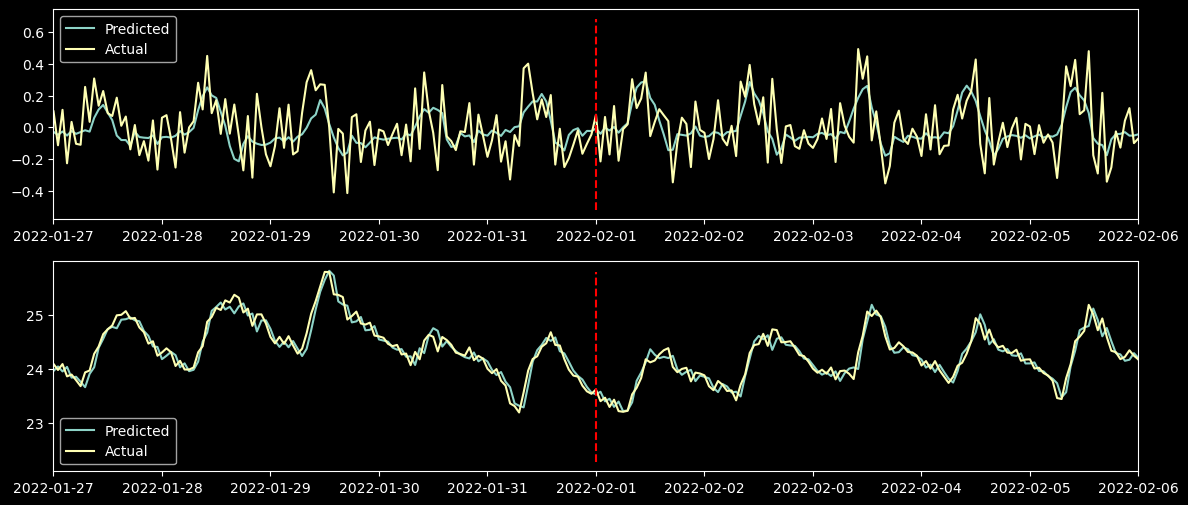

In [197]:
fit_and_test(ElasticNet(alpha=0.001, l1_ratio=0.01))

train score:	 0.5864529817990733
test score:	 0.1829813556698493

self RMSE:	 1.1808209614918053
pred RMSE:	 0.7452292710141043
train RMSE:	 0.609311828625196
test RMSE:	 0.9759015703518297

self RMSE:	 0.15630717613898473
pred RMSE:	 0.11753218493457378
train RMSE:	 0.09609626635753087
test RMSE:	 0.15391215603816708


KNeighborsRegressor()

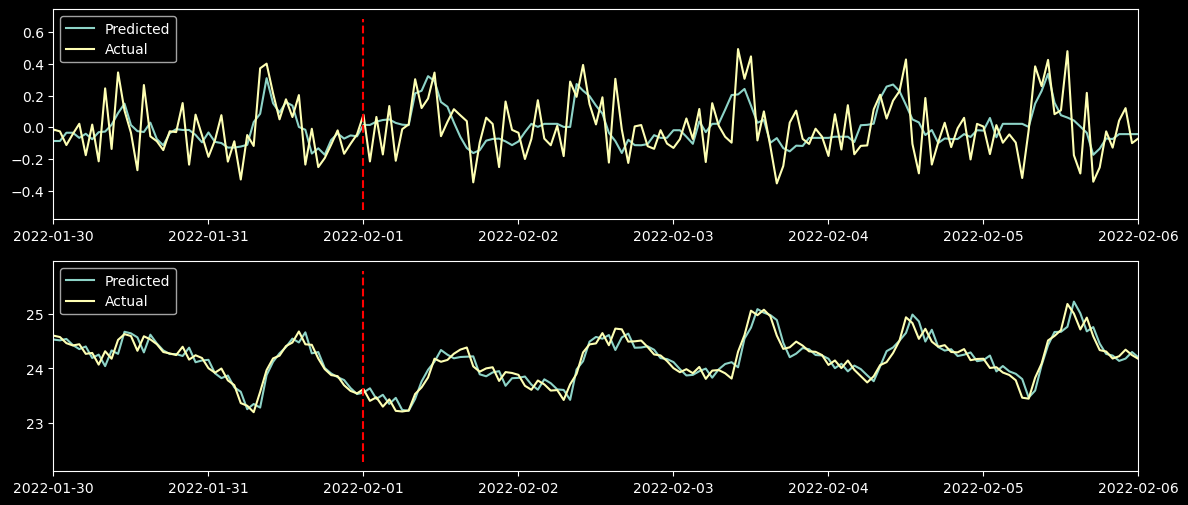

In [198]:
fit_and_test_scaled(KNeighborsRegressor(n_neighbors=5))

train score:	 0.5247639978700089
test score:	 0.23998417039016728

self RMSE:	 1.1808209614918053
pred RMSE:	 0.7563254269393617
train RMSE:	 0.6531784219753521
test RMSE:	 0.9412421174163548

self RMSE:	 0.15630717613898473
pred RMSE:	 0.11928219060530582
train RMSE:	 0.10301458903031627
test RMSE:	 0.1484459171361442


GradientBoostingRegressor(n_estimators=15)

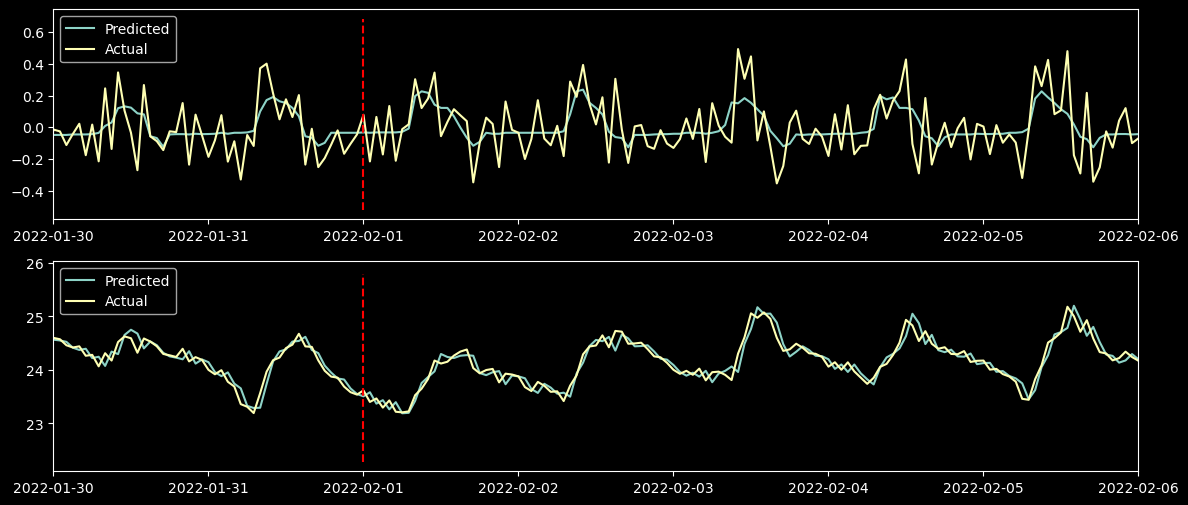

In [199]:
fit_and_test_scaled(GradientBoostingRegressor(n_estimators=15, learning_rate=0.1))


## VAR

array([<Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>], dtype=object)

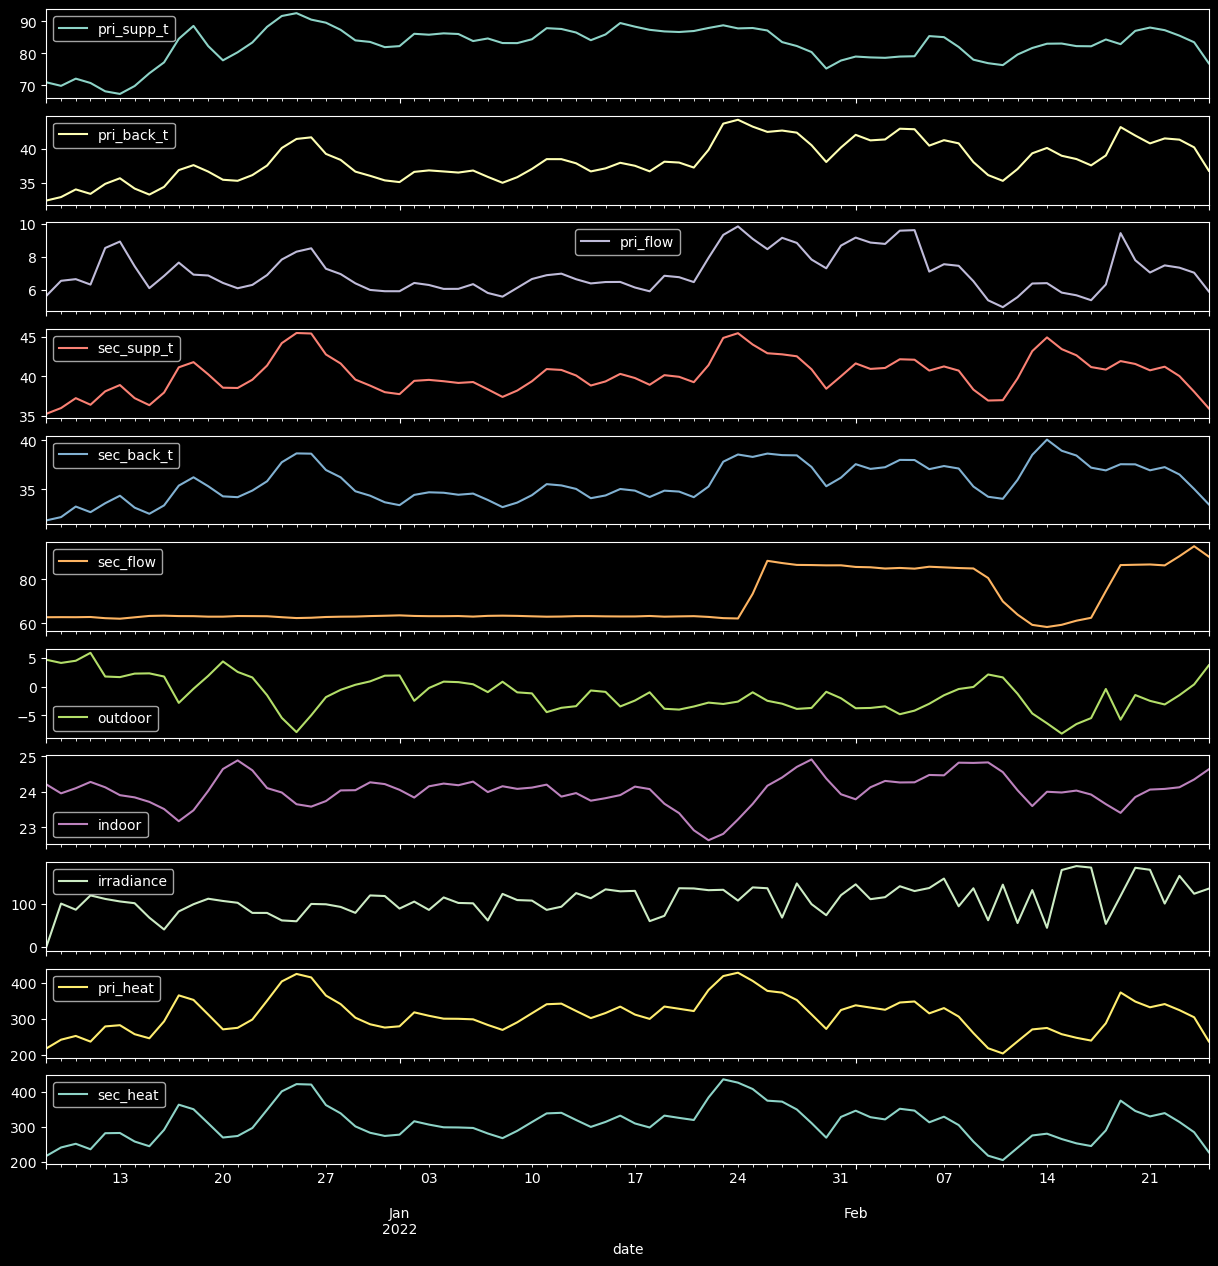

In [64]:
data_daily = data.resample('D').mean()
data_daily.plot(subplots=True, figsize=(15, 15))

In [67]:
X = data_daily.loc[:, data.columns != 'indoor']
y = data_daily.loc[:, 'indoor']
Xy = pd.concat([X, y], axis=1)
# Xy = np.log(Xy).diff().dropna()
pred_model = VAR(Xy)
model_fit = pred_model.fit(10)
model_fit.summary()

c:\ProgramData\miniconda3\lib\site-packages\statsmodels\tsa\vector_ar\var_model.py:1559: RuntimeWarning: invalid value encountered in sqrt
  stderr = np.sqrt(np.diag(self.cov_params()))


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 26, Dec, 2023
Time:                     14:07:43
---------------------------------------------------------------------
No. of Equations:         11.0000    BIC:                    -567.417
Nobs:                     70.0000    HQIC:                   -591.058
Log likelihood:           21360.7    FPE:               -3.04857e-272
AIC:                     -606.637    Det(Omega_mle):    -8.82490e-277
---------------------------------------------------------------------
Results for equation pri_supp_t
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                  0.010730         0.000002         4940.108           0.000
L1.pri_supp_t          0.590347         0.000000     26940366.734           0.000
L1.pri_back_t          0.123494         0.000

In [47]:
mdata = sm.datasets.macrodata.load_pandas().data
dates = mdata[['year', 'quarter']].astype(int).astype(str)
quarterly = dates["year"] + "Q" + dates["quarter"]
quarterly

0      1959Q1
1      1959Q2
2      1959Q3
3      1959Q4
4      1960Q1
        ...  
198    2008Q3
199    2008Q4
200    2009Q1
201    2009Q2
202    2009Q3
Length: 203, dtype: object

In [34]:
pred_model.data.dates

DatetimeIndex(['2021-12-08', '2021-12-09', '2021-12-10', '2021-12-11',
               '2021-12-12', '2021-12-13', '2021-12-14', '2021-12-15',
               '2021-12-16', '2021-12-17', '2021-12-18', '2021-12-19',
               '2021-12-20', '2021-12-21', '2021-12-22', '2021-12-23',
               '2021-12-24', '2021-12-25', '2021-12-26', '2021-12-27',
               '2021-12-28', '2021-12-29', '2021-12-30', '2021-12-31',
               '2022-01-01', '2022-01-02', '2022-01-03', '2022-01-04',
               '2022-01-05', '2022-01-06', '2022-01-07', '2022-01-08',
               '2022-01-09', '2022-01-10', '2022-01-11', '2022-01-12',
               '2022-01-13', '2022-01-14', '2022-01-15', '2022-01-16',
               '2022-01-17', '2022-01-18', '2022-01-19', '2022-01-20',
               '2022-01-21', '2022-01-22', '2022-01-23', '2022-01-24',
               '2022-01-25', '2022-01-26', '2022-01-27', '2022-01-28',
               '2022-01-29', '2022-01-30', '2022-01-31', '2022-02-01',
      

- date：时间
- pri_supp_t：⼀次⽹供⽔温度（摄⽒度）
- pri_back_t：⼀次⽹回⽔温度（摄⽒度）
- pri_flow：⼀次⽹流量（T/h）
- sec_supp_t：⼆次⽹供⽔温度（摄⽒度）
- sec_back_t：⼆次⽹回⽔温度（摄⽒度）
- sec_flow：⼆次⽹流量（T/h）
- outdoor：室外温度（摄⽒度）
- indoor：平均室内温度（摄⽒度）
- irradiance： 太阳辐射照度
- pri_delta_t：⼀次⽹供⽔温度与室外温度的差值
- sec_delta_t：⼆次⽹供⽔温度与室外温度的差值
 


<Axes: xlabel='date'>

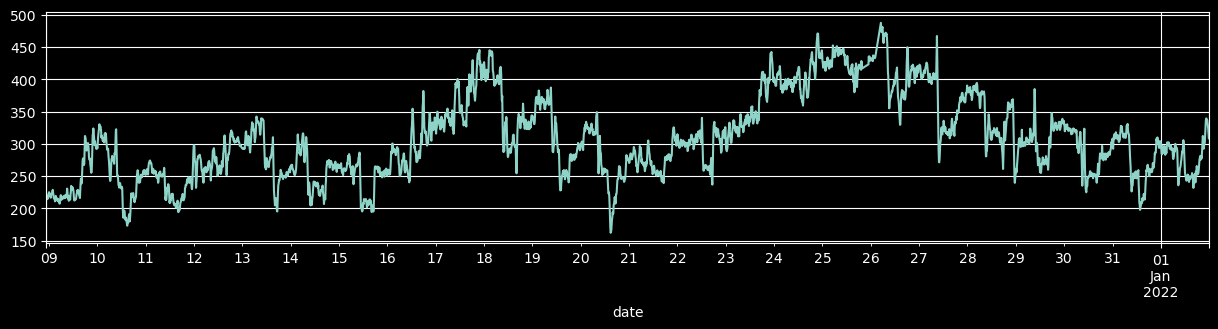

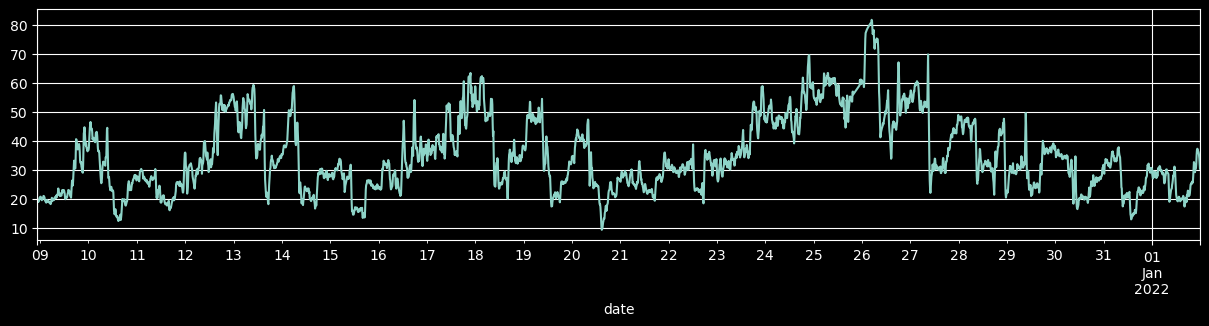

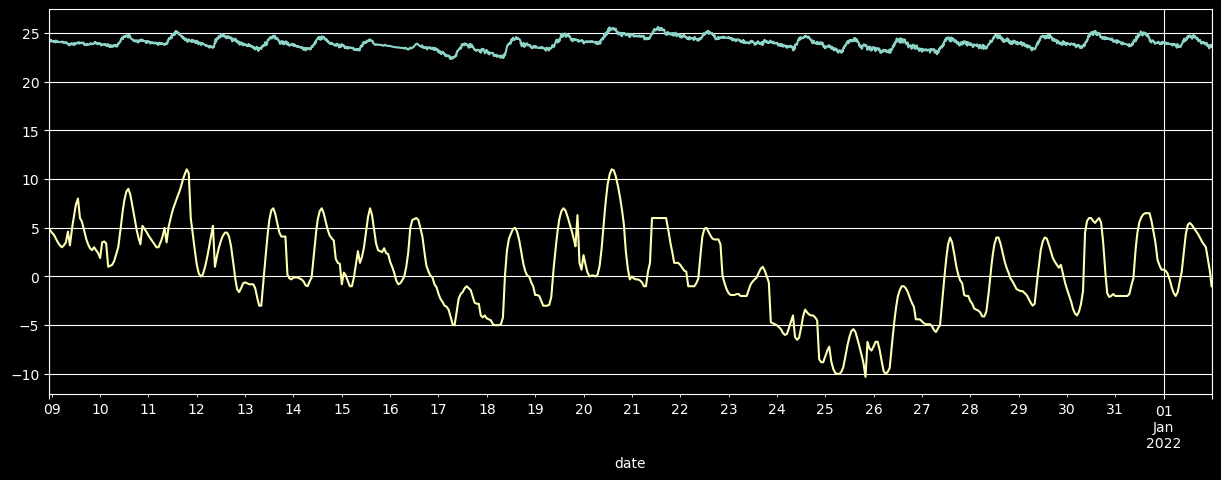

In [5]:
data['pri_energy'] = (data['pri_supp_t'] - data['pri_back_t']) * data['pri_flow']
data['sec_energy'] = (data['sec_supp_t'] - data['sec_back_t']) * data['pri_flow']
plt.figure(figsize=(15, 3))
data['pri_energy'][:'2022-1-1'].plot(figsize=(15, 3), grid=True)
plt.figure(figsize=(15, 3))
data['sec_energy'][:'2022-1-1'].plot(figsize=(15, 3), grid=True)
plt.figure(figsize=(15, 5))
data['indoor'][:'2022-1-1'].plot(grid=True)
data['outdoor'][:'2022-1-1'].plot(grid=True)

## Network

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class Preprocess(nn.Module):
    pass



<Axes: xlabel='date'>

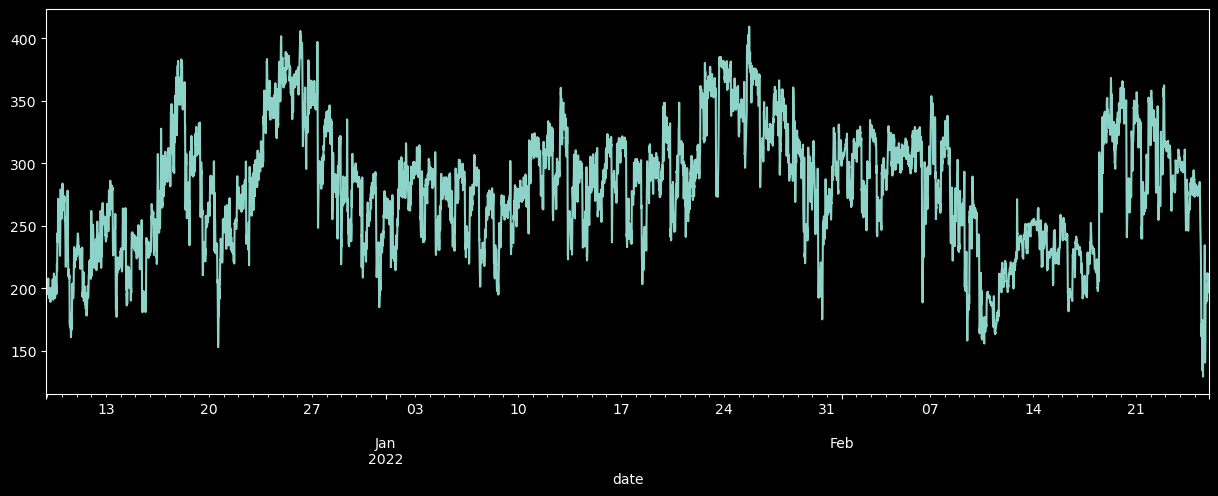

In [6]:
(data['pri_energy'] - data['sec_energy']).plot(figsize=(15, 5))

<Axes: xlabel='date'>

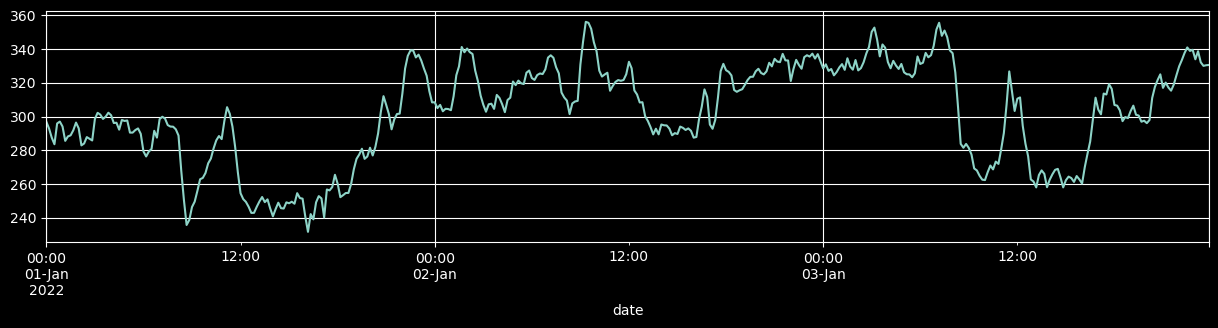

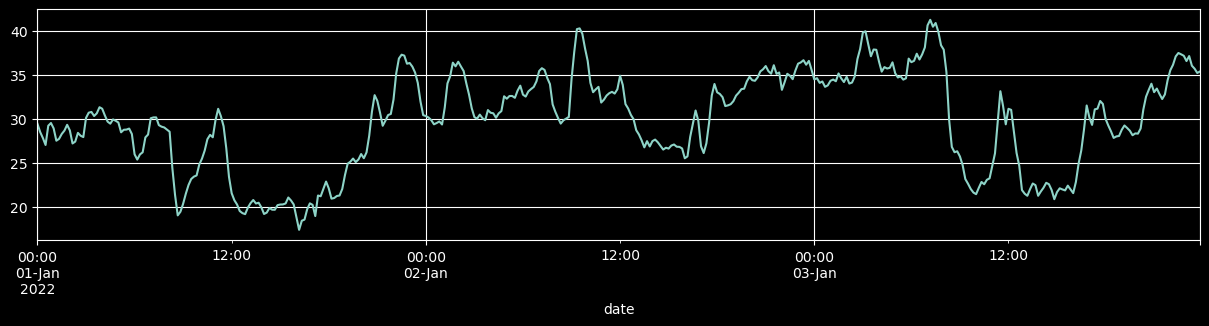

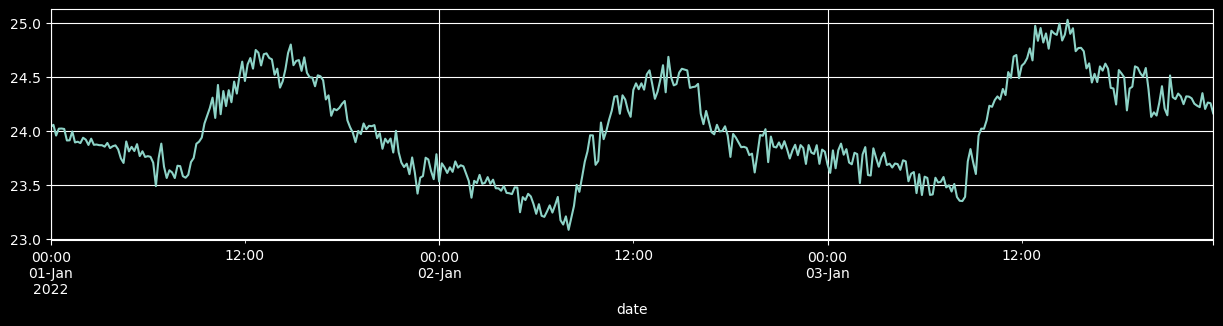

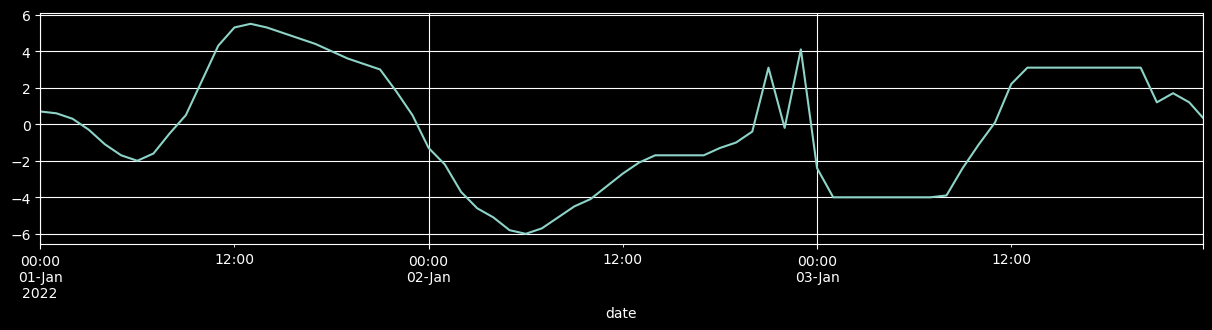

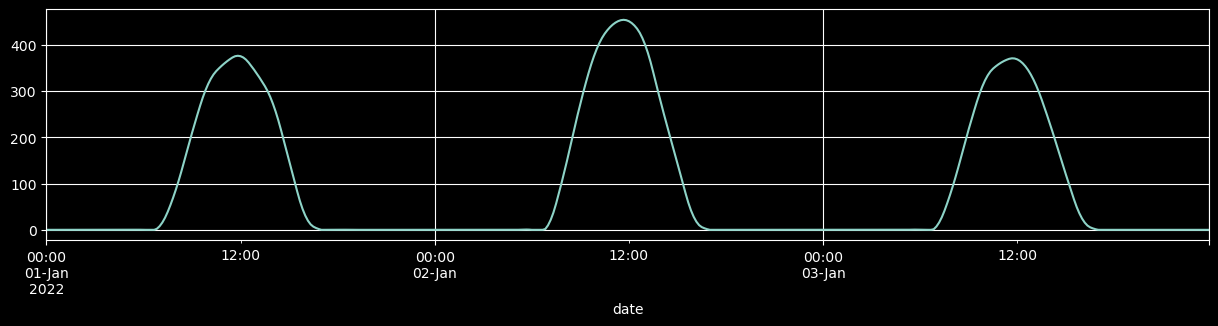

In [7]:
plt.figure(figsize=(15, 3))
data['pri_energy']['2022-1-1':'2022-1-3'].plot(figsize=(15, 3), grid=True)
plt.figure(figsize=(15, 3))
data['sec_energy']['2022-1-1':'2022-1-3'].plot(figsize=(15, 3), grid=True)
plt.figure(figsize=(15, 3))
data['indoor']['2022-1-1':'2022-1-3'].plot(grid=True)
plt.figure(figsize=(15, 3))
data['outdoor']['2022-1-1':'2022-1-3'].plot(grid=True)
plt.figure(figsize=(15, 3))
data['irradiance']['2022-1-1':'2022-1-3'].plot(grid=True)

<Axes: xlabel='date'>

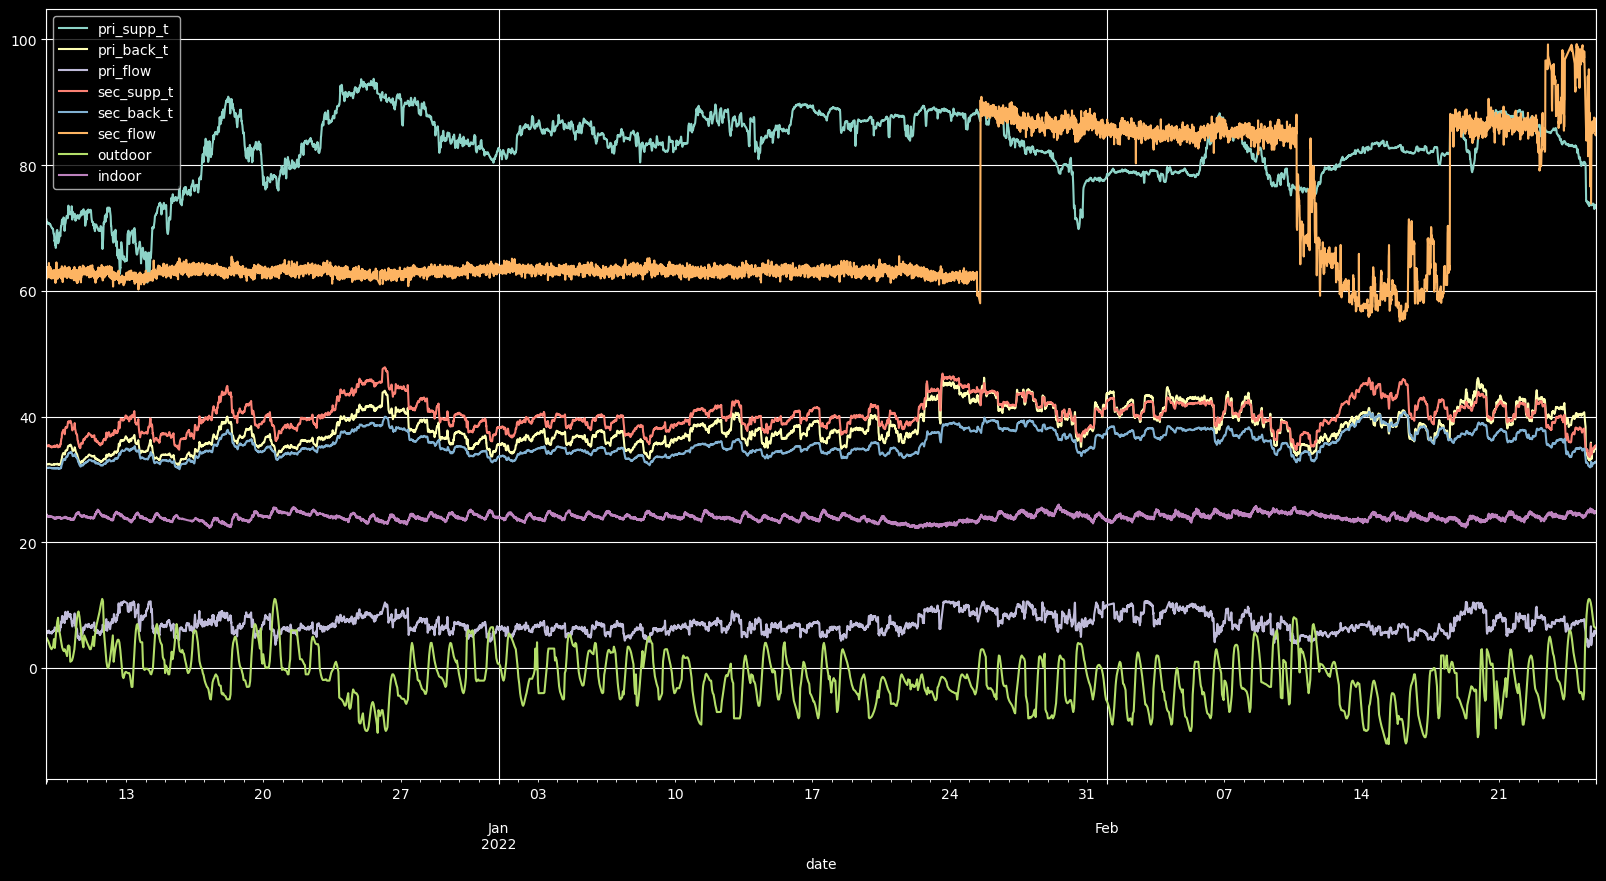

In [8]:
data[['pri_supp_t', 'pri_back_t', 'pri_flow', 'sec_supp_t', 'sec_back_t',
       'sec_flow', 'outdoor', 'indoor']].plot.line(figsize=(20, 10), grid=True)

# 'sec_flow'